# Segmentación de instancias 2D con Mask R-CNN




Un tipo diferente de segmentación es la denominada __segmentación de instancias__. La segmentación de instancias es una combinación de __detección de objetos__ y __segmentación de imágenes__.

__Se detecta cada objeto presente en una imagen, se obtienen sus cuadros delimitadores, se clasifica el objeto dentro del cuadro delimitador y se enmascara con un color único__. 

Se va a utilizar la arquitectura __Mask R-CNN__ propuesta por {cite:p}`he2017mask`, pertenecientes al FAIR (Facebook AI Research) extendiendo la arquitectura __Faster R-CNN__ ({cite:p}`girshick2015fast`) agregando una rama para predecir máscaras de segmentación en cada región de interés (RoI), en paralelo con la rama existente para clasificación y regresión del cuadro delimitador:

<img src="images/MaskRCNN_1.png" width="400px">

La rama de la máscara es un pequeño  Fully Convolutional Network (FCN) ({cite:p}`long2015fully`) aplicado a cada RoI, que predice una máscara de segmentación de píxel a píxel.

__Faster R-CNN__ proveía de 2 salidas: un cuadro delimitador y una etiqueta con la clase que lo identifica. A ello __Mask R-CNN__ añade una mascara que implica una alineación pixel a pixel más fina del objeto contenido en el cuadro delimitador.

{cite:p}`he2017mask` propusieron dos esquemas de arquitectura, una basada en una red residual ({cite:p}`he2016deep`) y otra en una red piramdial ({cite:p}`lin2017feature`). En el siguiente gráfico se observan ambos esquemas de funcionamiento. Los paneles izquierdo/derecho muestran los cabezales (__backbones__) de las redes troncales ResNet C4 y FPN, respectivamente, a los que se agrega una rama de máscara. Los números indican la resolución espacial y los canales. Las flechas indican las capas __conv__, __deconv__ o __fc__ como se puede inferir del contexto (conv conserva la dimensión espacial mientras que deconv la aumenta). Todas las conversiones son 3 × 3, excepto la conversión de salida que es 1 × 1, las desconversiones son 2 × 2 con paso 2 y se usa ReLU en capas ocultas. A la izquierda: '__res5__' denota la quinta etapa de ResNet, que por simplicidad se modifica para que la primera conv opere en un ROI de 7×7 con zancada 1. A la derecha: '×4' denota una pila de cuatro conversiones consecutivas.

<img src="images/MaskRCNN_2.png" width="500px">

Existe en un __modelo Mask R-CNN preentrenado__ que proporciona __PyTorch__ basado en una __red troncal ResNet-50-FPN__.

El modelo espera imágenes en lotes para inferencia y todos los píxeles deben estar dentro del rango $[0, 1]$. Por lo tanto, el formato de entrada al modelo será $[N, C, H, W]$. Aquí $N$ es el número de imágenes o el tamaño del lote, $C$ es la dimensión del canal de color, y $(H,  W)$ son la altura y la anchura de la imagen respectivamente. Es bastante simple y en el formato típico de PyTorch.

Sin embargo, el modelo genera mucho contenido. Es una combinación de detección de objetos y segmentación de imágenes. El modelo genera una lista de diccionarios que contienen los tensores resultantes. Formalmente, es del tipo __List[Dict[Tensor]]__. Con los siguientes contenidos, tomados del <a href="https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection">sitio web de PyTorch</a>:

- __Cajas (boxes)__ (__FloatTensor[N, 4]__): los cuadros predichos en formato __[x1, y1, x2, y2]__, con valores de __x__ entre 0 y W y valores de __y__ entre 0 y H.
- __Etiquetas (labels)__ (__Int64Tensor[N]__): las etiquetas predichas para cada imagen.
- __Puntuaciones (scores)__ (__Tensor[N]__): las puntuaciones de cada predicción.
- __Mascaras (masks)__ (__UInt8Tensor[N, 1, H, W]__): las máscaras predichas para cada instancia, en el __rango 0-1__. Para obtener las máscaras de segmentación final, se pueden establecer umbrales de las máscaras blandas, generalmente con un valor de 0,5 ( __máscara >= 0.5__).

Portanto, el diccionario contiene cuatro claves: __boxes__, __labels__, __scores__, y __masks__. Estas claves contienen los tensores resultantes como valores. Y hay que tener en cuenta que __se deben considerar los valores de las máscaras que son mayores o iguales a 0.5__.

## Importación de las librerías necesarias

In [1]:
import cv2
import numpy as np
import random
import torch
import argparse
from PIL import Image
import torchvision.models.segmentation
from torchvision.transforms import transforms as transforms
import os
import matplotlib.pyplot as plt

In [2]:
googleColaboratory = False
escribir_out = False ## Por defecto que no escriba el fichero de salida con las imagenes enmarcadas
downloadCOCOData = False
entrenamiento = False

In [3]:
if googleColaboratory:
    import google as goo
    goo.colab.drive.mount('/content/drive/')
    image_path = "/content/drive/My Drive/Colab Notebooks/data/coco_images"
    filename = "/content/drive/My Drive/Colab Notebooks/data/coco_images/cocoMaskRCNN.pt" 
else:
    image_path = "./data/coco_images"
    filename = "data/coco_images/cocoMaskRCNN.pt"

In [4]:
## N/A, no usado a partir de la versión 2017
## https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
COCO_INSTANCE_CATEGORY_NAMES = [
    '__fondo__', 'persona', 'bicicleta', 'coche', 'motocicleta', 'avion', 'autobus',
     'tren', 'camion', 'barco', 'semaforo', 'boca de incendios', 'N/A', 'STOP',
     'parquimetro', 'banco', 'pajaro', 'gato', 'perro', 'caballo', 'oveja', 'vaca',
     'elefante', 'oso', 'cebra', 'jirafa', 'N/A', 'mochila', 'paraguas', 'N/A', 'N/A',
     'bolso', 'corbata', 'maleta', 'disco volador', 'esquis', 'snowboard', 'pelota',
     'cometa', 'bate beisbol', 'guante beisbol', 'monopatin', 'tabla de surf', 'raqueta de tenis',
     'botella', 'N/A', 'copa vino', 'taza', 'tenedor', 'cuchillo', 'cuchara', 'tazon',
     'platano', 'manzana', 'sandwich', 'naranja', 'brocoli', 'zanahoria', 'perrito caliente', 'pizza',
     'rosquilla', 'pastel', 'silla', 'sofa', 'planta en maceta', 'cama', 'N/A', 'mesa de comedor',
     'N/A', 'N/A', 'inodoro', 'N/A', 'TV', 'portatil', 'raton', 'remoto', 'teclado', 'telefono celular',
     'microondas', 'horno', 'tostador', 'fregadero', 'nevera', 'N/A', 'libro',
     'reloj', 'jarron', 'tijeras', 'oso peluche', 'secador pelo', 'cepillo dientes', 'N/A'
]
coco_names = COCO_INSTANCE_CATEGORY_NAMES
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))
threshold = 0.965  ## Valor del umbral por defecto
imageSize=(256,128)


In [5]:
coco_names[1], COLORS[1], len(coco_names)

('persona', array([ 13.63221158,   2.81697553, 254.42965382]), 92)

### Función para obtener las salidas
Se Escribe una función simple para obtener los resultados del modelo después de la inferencia. Esta función proporcionará todos los tensores de salida necesarios para una correcta visualización de los resultados. Esta función se llama get_outputs().

La función get_outputs() acepta tres parámetros de entrada. El primero es la imagen de entrada, el segundo es el modelo Mask R-CNN y el tercero es el valor umbral. El valor umbral es una puntuación predefinida por debajo de la cual descartaremos todas las salidas para evitar demasiados falsos positivos. 

La función realiza la predicción de la imagen __image__ con el modelo Mask R-CNN __model__ que se vuelca sobre la variable __outputs__ que contiene la estructura de diccionarios explicados anteriormente.

La variable __outputs__ está preparada para manejar lotes de imagenes, aunque en este caso sólo se trata una única imagen por lo que se toman siempre los diccionario del elemento [0] de la lista.

La siguiente es la definición de la función.

In [6]:
def get_boxes_out(boxes):
    return [[(int(i[0]), int(i[1])), (int(i[0]) + int(i[2]), int(i[1]) + int(i[3]))]  for i in boxes]

def get_names_out(labels):
    return [coco_names[i] for i in labels]


def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

### Aplicar segmentación y dibujar cuadros delimitadores
Una vez que se tienen las etiquetas, las máscaras y los cuadros delimitadores, hay que aplicar las máscaras de color en el objeto y dibujar también los cuadros delimitadores.

Nuevamente se escribirá una función muy simple para eso. La función es draw_segmentation_map() que acepta cuatro parámetros de entrada. Son imagen, máscaras, cajas y etiquetas. La imagen es la imagen original sobre la que se aplicará las máscaras resultantes y dibujará los cuadros delimitadores alrededor de los objetos detectados. Además, las etiquetas ayudarán a poner el nombre de la clase encima de cada objeto.

La siguiente es la definición de la función.

In [7]:
def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    return image

### Preparar el modelo y definir la transformación
El siguiente paso es preparar el modelo Mask R-CNN.

In [8]:
# initialize the model
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

El siguiente bloque de código define las transformaciones que aplicaremos a las imágenes.

In [9]:
# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

### Leer la imagen y aplicar la segmentación de instancias
Se Proporcionará la ruta donde se encuentren una serie de archivos con extensión de imagenes (jpg). El siguiente bloque de código lee la imagen y le aplica una segmentación de instancia mediante el modelo Mask R-CNN.

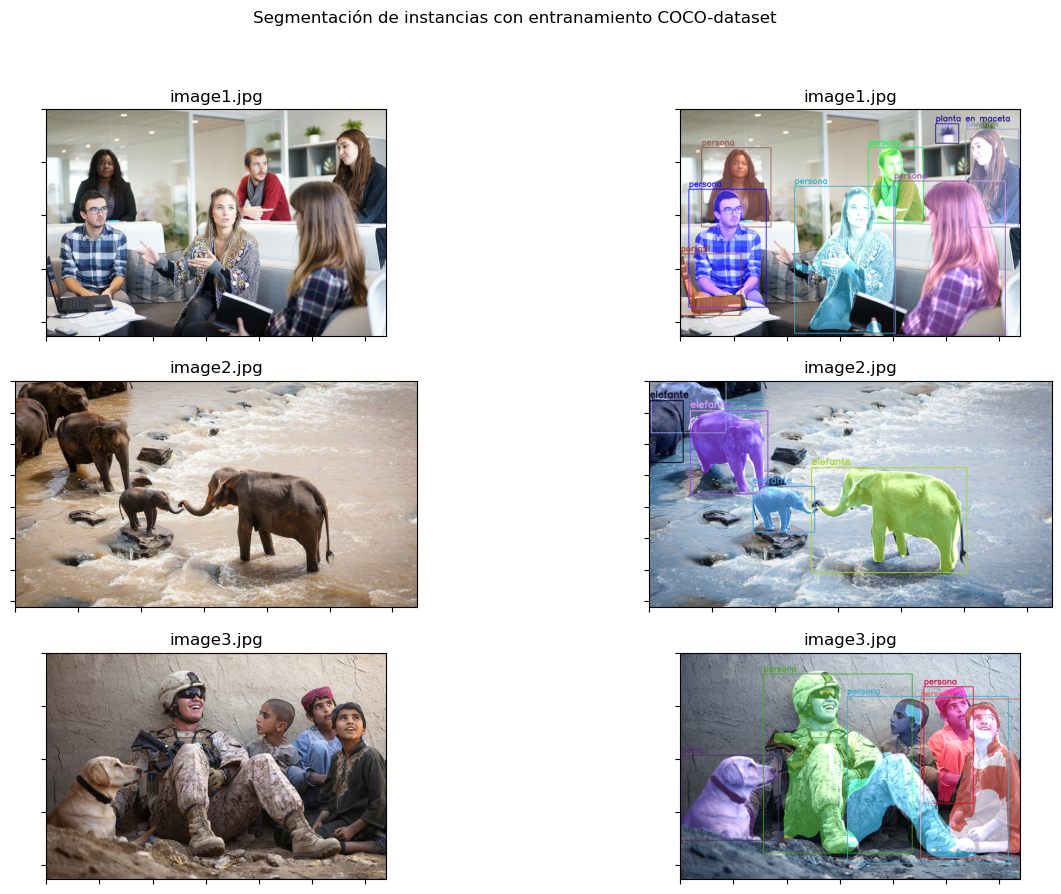

In [10]:
extensions = ['jpg','jpeg']
file_names = [fn for fn in os.listdir(image_path) if any(fn.endswith(ext) for ext in extensions)]
N = len(file_names)
if N > 10: N=10  ## Máximo 10 figuras
fig, axs = plt.subplots(N, 2, figsize=(15, 10))
fig.suptitle('Segmentación de instancias con entranamiento COCO-dataset')
for i in range(N):
    image = Image.open(image_path + "/" + file_names[i]).convert('RGB')
    # Mantener una copia de la imagen original para las funciones de OpenCV y aplicar máscaras
    orig_image = image.copy()
    # Transformar la imagen
    image = transform(image)
    # Agregar una dimensión de lote
    image = image.unsqueeze(0).to(device)
    masks, boxes, labels = get_outputs(image, model, threshold)
    result = draw_segmentation_map(orig_image, masks, boxes, labels)
    # Visualizar la imagen original
    axs[i, 0].set_title(file_names[i])
    axs[i, 0].imshow(orig_image)
    axs[i, 0].xaxis.set_ticklabels([])
    axs[i, 0].yaxis.set_ticklabels([])
    # Visualizar la imagen resultante
    axs[i, 1].set_title(file_names[i])
    axs[i, 1].imshow(result)
    axs[i, 1].xaxis.set_ticklabels([])
    axs[i, 1].yaxis.set_ticklabels([])
    # set the save path
    save_path = image_path + "/out/" + file_names[i]
    if escribir_out: cv2.imwrite(save_path, result)


## El conjunto COCO

__COCO__, acrónimo de __COmmon objects in COntext__ es un conjunto de datos orientado a la detección de objetos y a la segmentación (Tsung-Yi Lin et al., 2014). Está patrocinado por Microsoft y Facebook y colaboran especialistas en inteligencia artificial de Google. 

<a href="https://cocodataset.org/#home">La organización COCO</a>  permite descargar diferentes versiones (2014, 2015, 2017) en modo entrenamiento, test o validación. En este cuaderno se utiliza un conjunto de validación de 2017 por su reducido tamaño (5.000 objetos) para hacer una prueba de concepto de un proceso de entrenamiento. COCO está orientado a la segmentación de instancias por lo que permite entrenar un modelo Mask R-CNN. El formato de las anotaciones ("_targets"_) en COCO difieren algo en el formato con respecto a Mask R-CNN por lo que hay que realizar alguna pequeña transformación.

Especialmente hay que transformar las mascaras a través de una utilidades de la librería __pycocotools.mask__. Todo ello se desarrolla en la función __formatCOCO_MaskRCNN__:

In [11]:
import pycocotools.mask as cocomask
def formatCOCO_MaskRCNN(img, targCOCO, device, index=None, transform = None):
    #img = img.resize(imageSize)
    #[[(int(i[0]), int(i[1])), (int(i[0]) + int(i[2]), int(i[1]) + int(i[3]))]  for i in boxes]
    #bboxes = [targCOCO[i]['bbox'] for i in range(len(targCOCO))]
    iids = [targCOCO[i]['category_id'] for i in range(len(targCOCO))]
    idx = [targCOCO[i]['image_id'] for i in range(len(targCOCO))]
    areas = [targCOCO[i]['area'] for i in range(len(targCOCO))]
    crowds = [targCOCO[i]['iscrowd'] for i in range(len(targCOCO))]
    mmasks = []
    bboxes = []
    ie=0
    for i in range(len(targCOCO)):
        try:
            rle = cocomask.frPyObjects(targCOCO[i]['segmentation'], img.size[1], img.size[0])
            rle = cocomask.merge(rle)
            m = cocomask.decode(rle)
            mmasks.append(np.asarray(m))
            ## Se formatea la caja
            box = targCOCO[i]['bbox']
            bboxes.append([box[0], box[1], box[0] + box[2], box[1] + box[3]])
        except:
            ie+=1
        #mmasks.append(np.asarray(m)[:,:,0])
        #print("m=", len(m), len(m[0]), len(m[0][0]))
    #print(m[-1])
    boxes = torch.as_tensor(np.asarray(bboxes), dtype=torch.float32).to(device)
    #labels = torch.ones(len(iids), dtype=torch.int64).to(device)
    labels = torch.as_tensor(np.asarray(iids), dtype=torch.int64).to(device)
    masks = torch.as_tensor(np.asarray(mmasks), dtype=torch.uint8).to(device)
    image_id = torch.tensor(idx).to(device)
    area = torch.as_tensor(np.asarray(areas)).to(device)
    #iscrowd = torch.zeros(len(anns_obj), dtype=torch.int64).to(device)
    iscrowd = torch.as_tensor(np.asarray(crowds), dtype=torch.int64).to(device)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if ie > 0: print('Error formateando mascaras en idx={} en {}/{}'.format(index, ie, len(targCOCO)))
    #if transforms is not None:
        #img, target = transforms(img, target)
    return img, target

### Descarga del modelo COCO 

La descarga del modelo COCO se realiza desde la página de la organización COCO. Por un lado hay que descargar las imagenes y por otro un archivo con las anotaciones. Todo ello se recoge en la función __DescargarModeloCOCO__ que sólo será preciso realizar una vez y que se controla con el _flag_ __downloadCOCOData__ a _True_

In [12]:
#!pip install wget
import wget
import zipfile
def DescargarModeloCOCO():
    site_url = 'http://images.cocodataset.org/zips/val2017.zip'
    file_name = wget.download(site_url)
    with zipfile.ZipFile('val2017.zip', 'r') as zip_ref:
        zip_ref.extractall(image_path)
    site_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
    file_name = wget.download(site_url)
    with zipfile.ZipFile('annotations_trainval2017.zip', 'r') as zip_ref:
        zip_ref.extractall(image_path)
    print("done!")
    

In [13]:
if downloadCOCOData:
    DescargarModeloCOCO()
else:
    print("No está activa la descarga del modelo COCO")

No está activa la descarga del modelo COCO


In [14]:
import torchvision.datasets as dset
try:
    path2data=image_path + "/val2017"
    path2json=image_path + "/annotations/instances_val2017.json"
    coco_train = dset.CocoDetection(root = path2data, annFile = path2json)
    print('Número de ejemplos: ', len(coco_train))
except:
    print('No disponible el conjunto de entrada')
    coco_train = []

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
Número de ejemplos:  5000


## Realizar un entrenamiento con el conjunto COCO disponible

Para hacer el entrenamiento se hace una carga del modelo __maskrcnn_resnet50_fpn__ disponible en la librería __torchvision__ que puede ser sin pre-entrenamiento o con pre-entrenamiento.

In [15]:
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
# initialize the model
modelTrain = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
modelTrain.to(device).eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

### Carga del modelo pre-Entrenado

Además se carga la configuración local que se almacenó en fichero en el anterior entrenamiento

In [16]:
print("Fichero a recuperar=", filename, 'device=', device)
try:
  modelTrain.load_state_dict(torch.load(filename, map_location=torch.device(device))) #recovery trained model
  modelTrain.to(device);
  print(modelTrain)
except Exception as e:
  print('No ha sido posible carga el modelo pre-entrenado')
  print(e)

Fichero a recuperar= data/coco_images/cocoMaskRCNN.pt device= cpu
MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

### Optimizador

Se utiliza el optimizador estándar, en esta caso, la nueva versión __AdamW__.

In [17]:
optimizer = torch.optim.AdamW(params=modelTrain.parameters(), lr=1e-5)

### Carga de datos

La carga de datos extrae por indice la imagen y sus anotaciones, los formatea de acuerdo a las necesidades de MaskRCNN y hace las correspondientes transformaciones a Tensor que necesita el modelo de entrenamiento

In [18]:
def loadData(idx, cocoDS, device):
    image, target = cocoDS[idx]
    image, target = formatCOCO_MaskRCNN(image, target, device, index=idx)
    image = transform(image)
    # Agregar una dimensión de lote
    image = image.unsqueeze(0).to(device)
    #target = torch.Tensor(target)
    # Agregar una dimensión de lote
    #target = target.unsqueeze(0).to(device)
    return image, [target]

### Proceso de entrenamiento

In [19]:
num_epochs = 1
best_loss = 1e10
batchSize = 1
numLotes = int(np.floor(len(coco_train)/batchSize))
numT = len(coco_train)
scaler=None
print("device=", device)

# Train the model
for epoch in range(num_epochs):
    if not entrenamiento:
          print("No habilitada la opción de entrenamiento")
          break
    correct = 0
    total = 0
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    epoch_samples = 0
    epoch_loss = 0
    ie = 0
    modelTrain.train()
    for i in range(numLotes):
        #images, targets =  loadData(i, numT, batchSize, coco_train, device)
        images, targets =  loadData(i, coco_train, device)
        #print(targets)
        optimizer.zero_grad()
        try:
          loss_dict = modelTrain(images, targets)
          losses = sum(loss for loss in loss_dict.values())
          epoch_loss += losses / len(images)
   
          losses.backward()
          optimizer.step()
        except Exception as err:
          print(f"Unexpected {err=}, {type(err)=}")
          ie+=1

        epoch_samples += len(images)
        if i % 10 == 0:
          print("Batch=" + str(i) + "/" + str(numLotes))
        
    if epoch_loss < best_loss:
        print(f"Salvando el mejor modelo en {filename} con excepciones {ie}/{len(coco_train)}")
        best_loss = epoch_loss
        torch.save(modelTrain.state_dict(), filename)
           
print ('Final de Entrenamiento')

device= cpu
No habilitada la opción de entrenamiento
Final de Entrenamiento


### Resultado Gráfico

In [20]:
device='cpu'
print("Fichero a recuperar=", filename, 'device=', device)
try:
    modelTrain.load_state_dict(torch.load(filename, map_location=torch.device(device))) #recovery trained model
    modelTrain.to(device).eval();
    print(modelTrain)
except Exception as e:
    print('No ha sido posible carga el modelo pre-entrenado')
    print(e)

Fichero a recuperar= data/coco_images/cocoMaskRCNN.pt device= cpu
MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

### Resultado gráfico

Error formateando mascaras en idx=None en 1/18


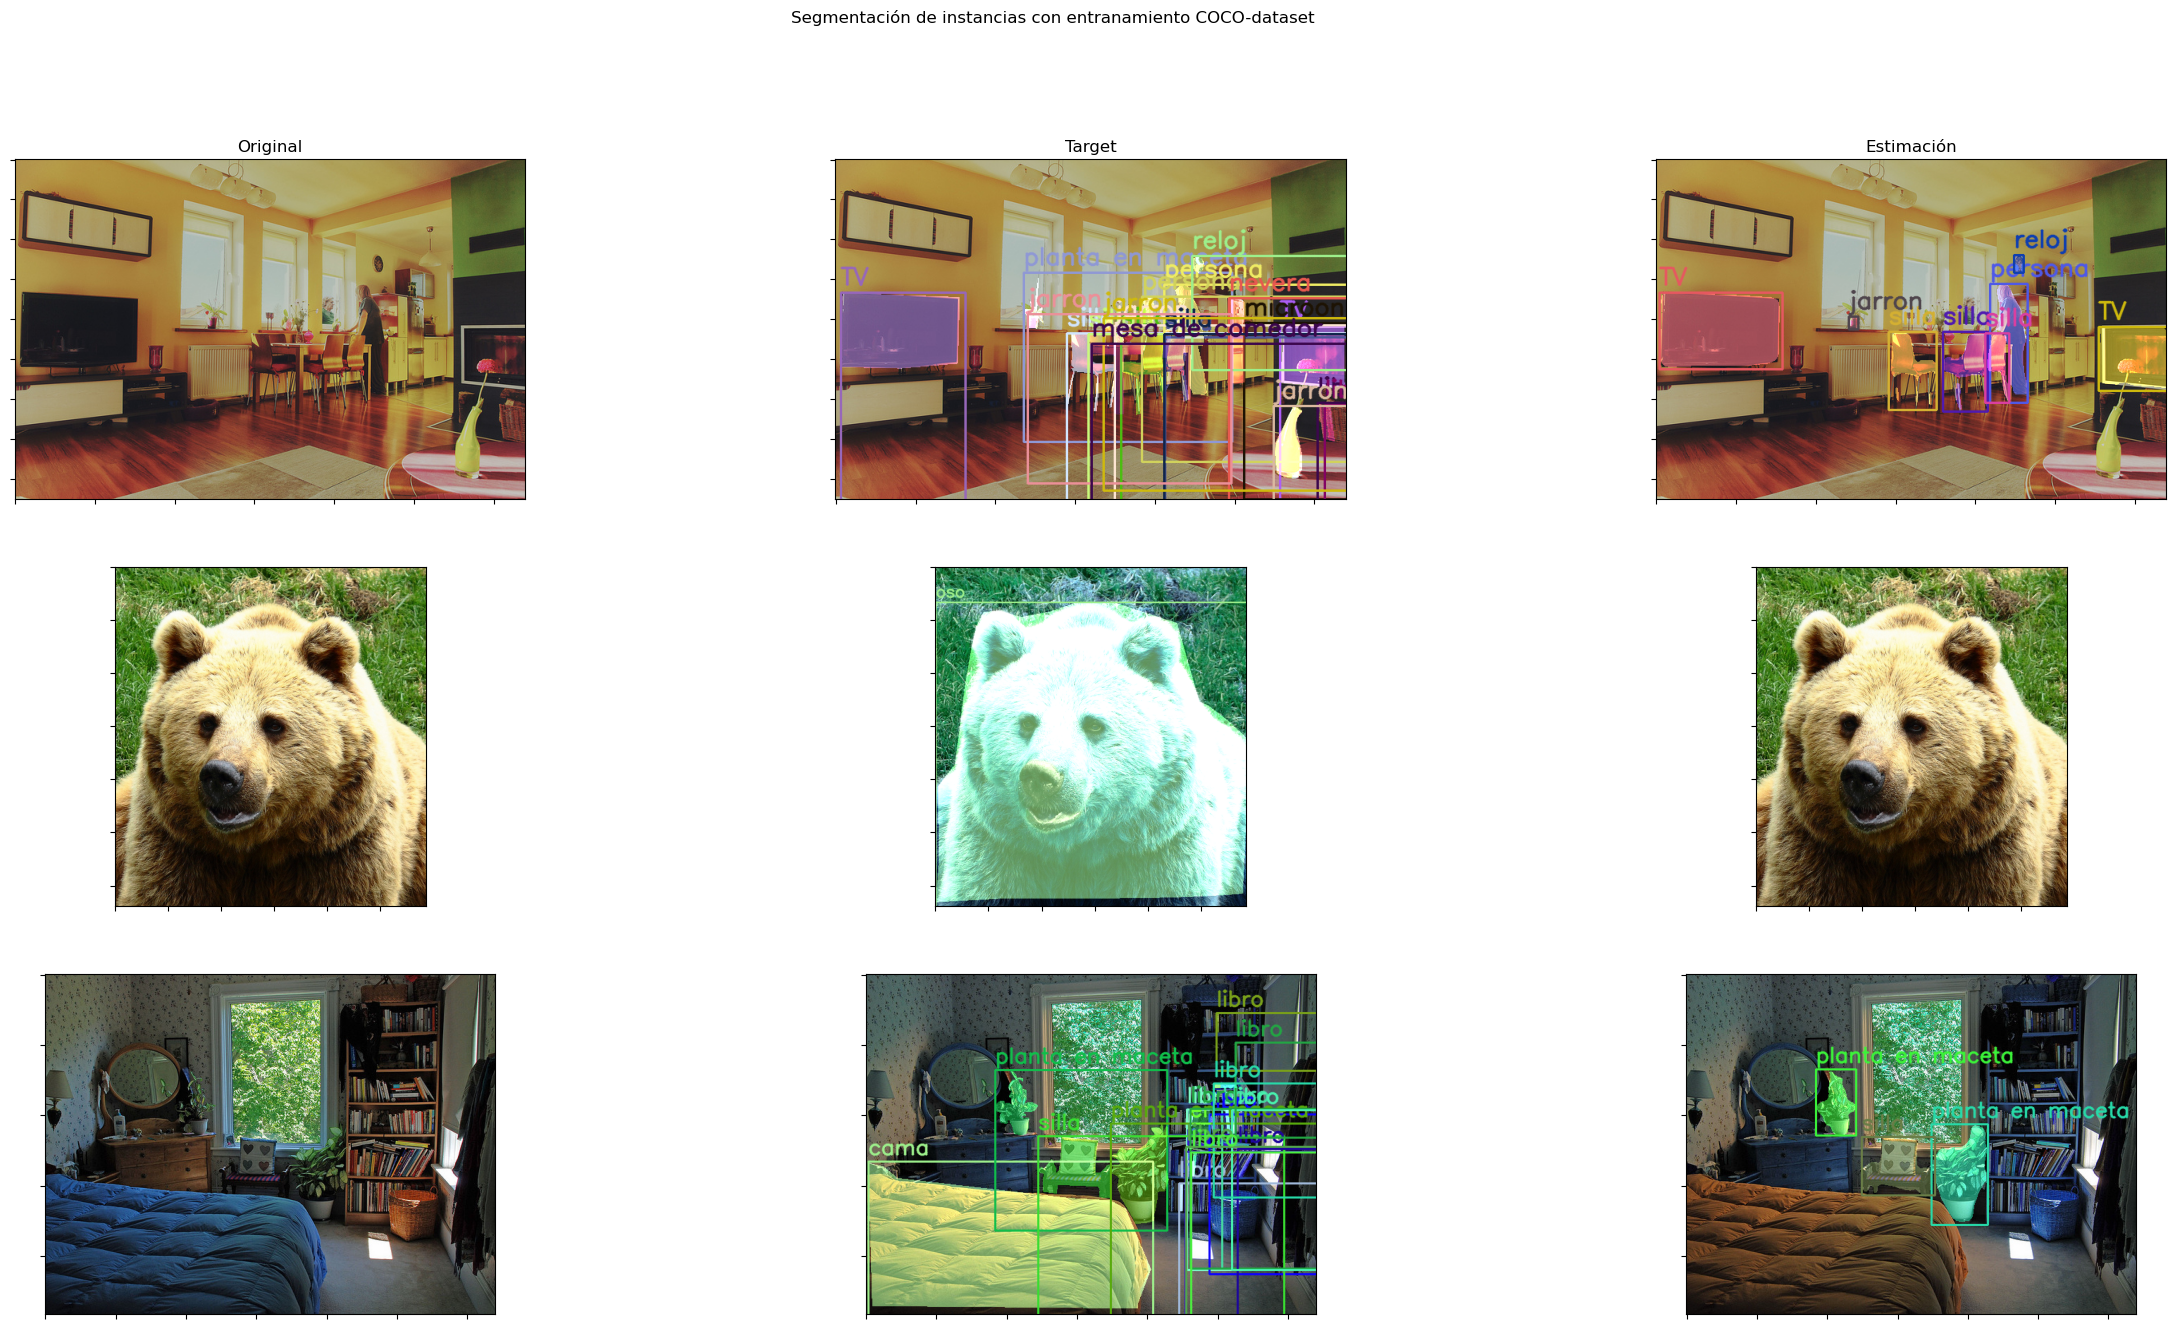

In [21]:
N = min(3, len(coco_train))
if N>0:
    fig, axs = plt.subplots(N, 3, figsize=(30, 15))
    fig.suptitle('Segmentación de instancias con entranamiento COCO-dataset')
    axs[0, 0].set_title('Original')
    axs[0, 1].set_title('Target')
    axs[0, 2].set_title('Estimación')
else:
    print('No hay conjunto de pruebas disponible')
for i in range(N):
    #image = Image.open(image_path + "/" + file_names[i]).convert('RGB')
    image, target = coco_train[i]
    img2, target2 = formatCOCO_MaskRCNN(image, target, device)
    # Mantener una copia de la imagen original para las funciones de OpenCV y aplicar máscaras
    orig_image = image.copy()
    # Transformar la imagen
    image = transform(image)
    # Agregar una dimensión de lote
    image = image.unsqueeze(0).to(device)
    masks, boxes, labels = get_outputs(image, modelTrain, threshold)
    result2 = draw_segmentation_map(orig_image, masks, boxes, labels)
    ## Resultado del objetivo cargado en COCO
    result = draw_segmentation_map(orig_image, target2['masks'], get_boxes_out(target2['boxes']), get_names_out(target2['labels']))
    # Visualizar la imagen original
    #axs[i, 0].set_title(file_names[i])
    axs[i, 0].imshow(orig_image)
    axs[i, 0].xaxis.set_ticklabels([])
    axs[i, 0].yaxis.set_ticklabels([])
    # Visualizar la imagen resultante
    #axs[i, 1].set_title(file_names[i])
    axs[i, 1].imshow(result)
    axs[i, 1].xaxis.set_ticklabels([])
    axs[i, 1].yaxis.set_ticklabels([])
    axs[i, 2].imshow(result2)
    axs[i, 2].xaxis.set_ticklabels([])
    axs[i, 2].yaxis.set_ticklabels([])
    # set the save path
    save_path = image_path + "/out/" + file_names[i]
    if escribir_out: cv2.imwrite(save_path, result)
